In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import TheilSenRegressor
from pyscipopt import Model, quicksum, multidict
import os
os.chdir('/Users/vitalijstarikov/PycharmProjects/Shell_hachakton_2023')

In [66]:
data = pd.read_csv('data/Biomass_History.csv', index_col=0)
dist = pd.read_csv('data/Distance_Matrix.csv', index_col=0)

In [57]:
def preprocessing(data ,dist):
    total_biomass = max(data['2018'].sum(), data['2019'].sum())
    average_biomass = data.iloc[:, -2:].mean(axis=1)
    sorted_dist = dist.sum(axis=1).sort_values(ascending=True).reset_index()
    indices = []
    biomass_to_collect = []
    i = 0
    while sum(biomass_to_collect) <= 0.85 * total_biomass:
        biomass_to_collect.append(average_biomass[sorted_dist.iloc[i,0]])
        indices.append(sorted_dist.iloc[i,0])
        i += 1

    return indices

In [58]:
def predict_biomass(data):
    reg = TheilSenRegressor()
    X = np.arange(0,8).reshape(-1,1)
    pred_list = []
    for i in range(0, len(data)):
        y = data.iloc[i, 2:].values.ravel()
        reg.fit(X,y)
        preds = reg.predict(np.array([8, 9]).reshape(-1, 1))
        pred_list.append(list(preds))
    pred_df = pd.DataFrame(np.array(pred_list).squeeze(), columns=['2018', '2019'],
                               index=np.arange(0, len(data)))
    data_predicted = pd.concat([data, pred_df], axis=1)

    return data_predicted

In [59]:
def CFLP(I,J,d,M,c,n):
    model = Model("flp")
    x,y = {},{}

    for j in J:
        y[j] = model.addVar(vtype="B", name="y(%s)"%j)
        for i in I:
            x[i,j] = model.addVar(vtype="C", name="x(%s,%s)"%(i,j))
    for i in I:
        model.addCons(quicksum(x[i,j] for j in J) == d[i], "Demand(%s)"%i) # All demands should be met
    for j in M:
        model.addCons(quicksum(x[i,j] for i in I) <= M[j]*y[j], "Capacity(%s)"%i) # All facility should not violate capacity constraint
    for (i,j) in x:
        model.addCons(x[i,j] <= d[i]*y[j], "Strong(%s,%s)"%(i,j)) # Can't be delivered more than demand
    model.addCons(quicksum(y[j] for j in J) <= n, "Number_of_facilities(%s)"%j)
    model.setObjective(
        quicksum(M[j]*y[j] - quicksum(x[i,j] for i in I) for j in J) +
        0.001 * quicksum(c[i,j]*x[i,j] for i in I for j in J),
        "minimize")
    model.data = x,y
    return model

In [60]:
def CFLP_second_year(I,J,d,M,c,y):
    model = Model("flp")
    x = {}

    for j in J:
        for i in I:
            x[i,j] = model.addVar(vtype="C", name="x(%s,%s)"%(i,j))
    for i in I:
        model.addCons(quicksum(x[i,j] for j in J) == d[i], "Demand(%s)"%i) # All demands should be met
    for j in M:
        model.addCons(quicksum(x[i,j] for i in I) <= M[j]*y[j], "Capacity(%s)"%i) # All facility should not violate capacity constraint
    for (i,j) in x:
        model.addCons(x[i,j] <= d[i]*y[j], "Strong(%s,%s)"%(i,j)) # Can't be delivered more than demand
    model.setObjective(
        quicksum(M[j]*y[j] - quicksum(x[i,j] for i in I) for j in J) +
        0.001 * quicksum(c[i,j]*x[i,j] for i in I for j in J),
        "minimize")
    model.data = x
    return model

In [61]:
def kmedian(I, J, c, k):
    model = Model("k-median")
    x, y = {}, {}
    for j in J:
        y[j] = model.addVar(vtype="B", name="y(%s)" % j)
        for i in I:
            x[i, j] = model.addVar(vtype="B", name="x(%s,%s)" % (i, j))
    for i in I:
        model.addCons(quicksum(x[i, j] for j in J) == 1, "Assign(%s)" % i)
        for j in J:
            model.addCons(x[i, j] <= y[j], "Strong(%s,%s)" % (i, j))
    model.addCons(quicksum(y[j] for j in J) == k, "Facilities")
    model.setObjective(quicksum(c[i, j] * x[i, j] for i in I for j in J), "minimize")
    model.data = x, y

    return model

### Prediction & preprocessing

In [67]:
prediction = predict_biomass(data)
prediction

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24.66818,71.33144,8.475744,8.868568,9.202181,6.023070,10.788374,6.647325,7.387925,5.180296,6.941737,6.691071
1,24.66818,71.41106,24.029778,28.551348,25.866415,21.634459,34.419411,27.361908,40.431847,42.126945,43.204805,45.605177
2,24.66818,71.49069,44.831635,66.111168,56.982258,53.003735,70.917908,42.517117,59.181629,73.203232,72.864142,75.675037
3,24.66818,71.57031,59.974419,80.821304,78.956543,63.160561,93.513924,70.203171,74.536720,101.067352,98.593218,102.801545
4,24.66818,71.64994,14.653370,19.327524,21.928144,17.899586,19.534035,19.165791,16.531315,26.086885,23.437156,24.141703
...,...,...,...,...,...,...,...,...,...,...,...,...
2413,20.15456,72.84432,5.199882,4.516778,4.321080,2.658953,5.113997,5.301668,6.419223,5.321604,5.509466,5.651458
2414,20.15456,72.92394,0.122287,0.126717,0.101494,0.111509,0.121749,0.122467,0.145785,0.120626,0.124472,0.125093
2415,20.15456,73.00357,0.039415,0.040843,0.032713,0.035941,0.039241,0.039473,0.046989,0.038879,0.040218,0.040564
2416,20.15456,73.08319,2.719220,1.370163,0.818687,1.205721,1.316443,1.324201,1.576338,1.304297,1.265245,1.253341


Text(0.5, 1.0, 'Spatial Biomass Distribution')

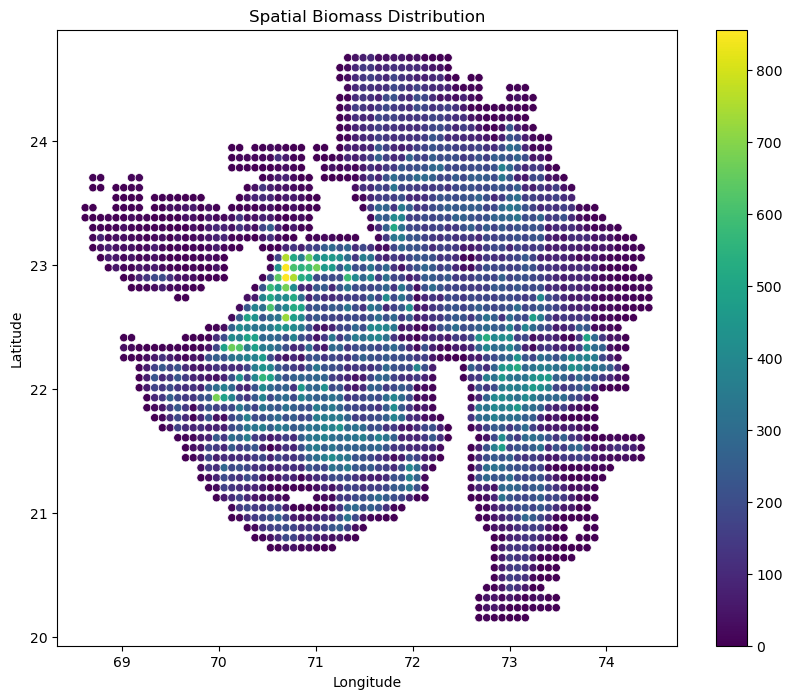

In [68]:
year = '2018'

plt.figure(figsize=(10, 8))
ax = sns.scatterplot(data=prediction, x='Longitude', y='Latitude', hue=year, palette='viridis')

norm = plt.Normalize(prediction[year].min(), prediction[year].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
ax.get_legend().remove()
ax.figure.colorbar(ax=ax, mappable=sm)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Biomass Distribution')

In [69]:
indices = preprocessing(prediction, dist)
prediction = prediction.iloc[indices,:]
dist = dist.iloc[indices, indices]
prediction

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
1161,22.57257,71.80919,235.627228,292.933227,109.337555,218.015884,273.378418,295.026428,228.876297,278.418823,283.128747,289.109438
1167,22.57257,72.28694,215.448059,185.085129,163.928558,191.308227,152.546555,216.821899,150.394745,151.264252,136.874322,129.972081
1110,22.65317,72.12769,96.775566,65.974236,54.824028,70.381401,60.916252,72.966026,66.482132,74.143700,69.036928,69.350633
1166,22.57257,72.20732,189.149582,163.966141,135.268372,158.399139,138.744781,173.667236,138.247620,142.772217,128.016128,122.879006
1162,22.57257,71.88882,129.218277,159.620987,71.338722,123.937584,140.206162,144.786942,125.013153,157.485489,143.588737,145.870537
...,...,...,...,...,...,...,...,...,...,...,...,...
1940,21.52477,73.24244,152.239365,165.956528,113.632698,219.517029,264.666016,217.604568,233.130936,246.566513,260.161627,273.650861
32,24.50698,71.49069,121.033234,177.738617,170.079651,111.813431,164.977264,118.140984,150.813324,134.183136,137.772906,132.762417
1436,22.25017,74.03869,33.334621,32.695362,82.081978,82.081978,82.081978,32.695362,88.723534,33.334621,80.729079,85.418798
1445,22.16957,69.73894,56.511650,15.420983,76.651039,77.357429,76.905403,15.290696,24.578590,56.807507,56.716721,56.371425


Text(0.5, 1.0, 'Spatial Biomass Distribution')

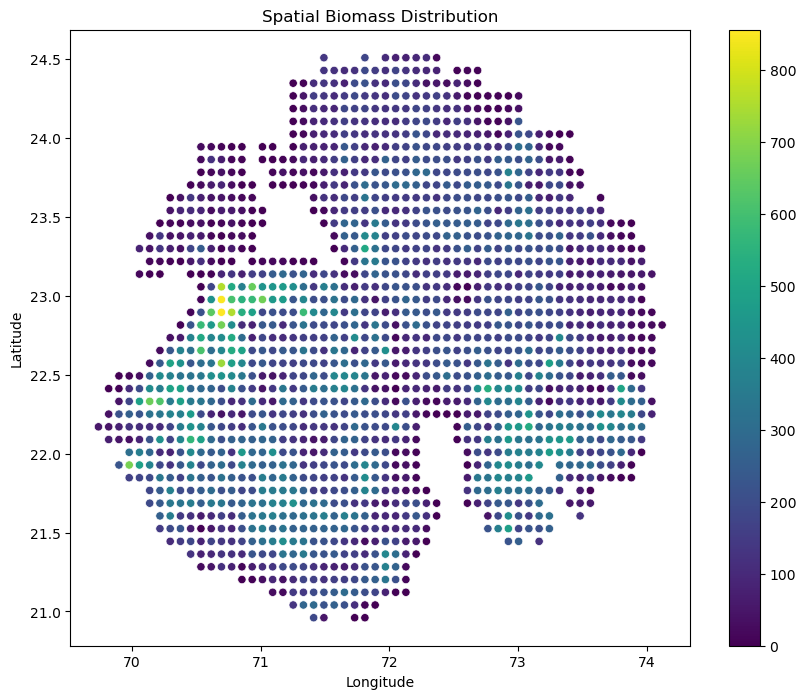

In [70]:
year = '2018'

plt.figure(figsize=(10, 8))
ax = sns.scatterplot(data=prediction, x='Longitude', y='Latitude', hue=year, palette='viridis')

norm = plt.Normalize(prediction[year].min(), prediction[year].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
ax.get_legend().remove()
ax.figure.colorbar(ax=ax, mappable=sm)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Biomass Distribution')

In [16]:
number_of_depots = max(int(prediction['2018'].sum() / 20000) + 1, int(prediction['2019'].sum() / 20000) + 1)
number_of_depots

18

## First year 2018

### Depot locations

In [39]:
year = '2018'
max_number_of_depots = 25
depot_cap = 20000

# Get site indices and its biomass demand
biomass = prediction[year]
site_locations, biomass_demand = multidict(dict(biomass))

# Get indices where depot can be located
capacity = pd.Series(depot_cap, index=prediction[year].index) # assuming all possible locations
possible_depot_locations, depot_capacity = multidict(dict(capacity))

# Cost matrix of transport from site_indices to depot_indices
site_depot_dist = dist.iloc[site_locations, possible_depot_locations].reset_index().melt(id_vars='index')
site_depot_dist['variable'] =  site_depot_dist['variable'].astype('int')
site_depot_dist = {(row[0], row[1]):row[2] for row in site_depot_dist.values}
site_depot_dist

{(0.0, 0.0): 0.0,
 (1.0, 0.0): 11.3769,
 (2.0, 0.0): 20.4557,
 (3.0, 0.0): 38.1227,
 (4.0, 0.0): 45.381,
 (5.0, 0.0): 54.9915,
 (6.0, 0.0): 78.968,
 (7.0, 0.0): 118.675,
 (8.0, 0.0): 102.6639,
 (9.0, 0.0): 113.4309,
 (10.0, 0.0): 122.5989,
 (11.0, 0.0): 129.9333,
 (12.0, 0.0): 152.2615,
 (13.0, 0.0): 161.53289999999998,
 (14.0, 0.0): 25.7233,
 (15.0, 0.0): 9.5233,
 (16.0, 0.0): 14.0595,
 (17.0, 0.0): 24.3136,
 (18.0, 0.0): 37.8461,
 (19.0, 0.0): 45.7319,
 (20.0, 0.0): 56.948,
 (21.0, 0.0): 118.5574,
 (22.0, 0.0): 112.3636,
 (23.0, 0.0): 105.9454,
 (24.0, 0.0): 107.981,
 (25.0, 0.0): 111.788,
 (26.0, 0.0): 120.5127,
 (27.0, 0.0): 146.31529999999998,
 (28.0, 0.0): 139.4,
 (29.0, 0.0): 30.3211,
 (30.0, 0.0): 21.160400000000003,
 (31.0, 0.0): 21.4279,
 (32.0, 0.0): 30.824,
 (33.0, 0.0): 33.2092,
 (34.0, 0.0): 50.2884,
 (35.0, 0.0): 64.80890000000001,
 (36.0, 0.0): 72.04180000000001,
 (37.0, 0.0): 108.9288,
 (38.0, 0.0): 88.04780000000001,
 (39.0, 0.0): 97.8621,
 (40.0, 0.0): 104.9229,
 (41

In [ ]:
model = kmedian(I = site_locations,
                J = possible_depot_locations,
                c = site_depot_dist,
                k = number_of_depots)
model.optimize()
x,y = model.data
EPS = 1.e-6
depot_locations = [j for j in y if model.getVal(y[j]) > EPS]
depot_routes = [(i,j) for (i,j) in x if model.getVal(x[i,j]) > EPS]
print("Optimal value=", model.getObjVal())
print("Depots at nodes:", depot_locations)
print("Site-Depot routes (from,to):", depot_routes)

In [36]:
boolean_depot_locations = {j:model.getVal(y[j]) for j in possible_depot_locations}

In [38]:
model3 = CFLP_second_year(I = site_locations,
                          J = possible_depot_locations,
                          d = biomass_demand,
                          M = depot_capacity,
                          c = site_depot_dist,
                          y = boolean_depot_locations)
model3.optimize()
EPS = 1.e-6
x3 = model3.data
depot_routes = [(i,j) for (i,j) in x3 if model3.getVal(x3[i,j]) > EPS]
print("Optimal value=", model3.getObjVal())
print("Site-Depot routes (from,to):", depot_routes)

Optimal value= 353178.7455490071
Site-Depot routes (from,to): [(229, 136), (138, 136), (136, 136), (217, 217), (338, 217), (101, 217), (705, 457), (460, 457), (574, 457), (404, 457), (500, 688), (688, 688), (760, 688), (661, 921), (856, 921), (1040, 921), (970, 975), (790, 975), (975, 975), (1006, 1065), (1065, 1065), (1155, 1100), (1153, 1100), (1157, 1100), (1101, 1100), (1207, 1100), (1307, 1307), (1560, 1307), (1236, 1426), (1426, 1426), (1492, 1492), (1615, 1492), (1432, 1492), (1490, 1492), (1643, 1643), (1463, 1643), (1639, 1643), (1704, 1815), (1537, 1815), (1868, 1815), (1938, 1938), (2049, 1938), (2067, 2067), (2069, 2067), (1901, 2067), (2108, 2108), (2215, 2215), (2414, 2373), (2345, 2373), (2373, 2373)]


In [14]:
model1 = CFLP(I = site_locations,
              J = possible_depot_locations,
              d = biomass_demand,
              M = depot_capacity,
              c = site_depot_dist,
              n = max_number_of_depots)
model1.optimize()
EPS = 1.e-6
x,y = model1.data
depot_routes = [(i,j) for (i,j) in x if model1.getVal(x[i,j]) > EPS]
depot_locations = [j for j in y if model1.getVal(y[j]) > EPS]
print("Optimal value=", model1.getObjVal())
print("Depots at nodes:", depot_locations)
print("Site-Depot routes (from,to):", depot_routes)

Optimal value= 13526.187144551646
Depots at nodes: [1161]
Site-Depot routes (from,to): [(1787, 1161), (1474, 1161), (2098, 1161), (841, 1161), (1001, 1161), (1410, 1161), (1859, 1161), (226, 1161), (781, 1161), (2342, 1161), (1297, 1161), (1100, 1161), (2124, 1161), (1336, 1161), (2052, 1161), (2120, 1161), (2015, 1161), (364, 1161), (595, 1161), (1087, 1161), (1021, 1161), (912, 1161), (1321, 1161), (1539, 1161), (2073, 1161), (2378, 1161), (116, 1161), (773, 1161), (1186, 1161), (2139, 1161), (293, 1161), (380, 1161), (2379, 1161), (592, 1161), (940, 1161), (2242, 1161), (2363, 1161), (1680, 1161), (1751, 1161), (2295, 1161), (877, 1161), (1288, 1161), (12, 1161), (686, 1161), (1189, 1161), (2158, 1161), (1532, 1161), (1694, 1161), (960, 1161), (1667, 1161)]


### Refinery locations

In [120]:
year = '2018'
max_number_of_refineries = 5
cap = 100000
EPS = 1.e-6

# Get pellet demand at each depot
pellet_demand = {dl:sum([model1.getVal(x[sl,dl]) for sl in site_locations if model1.getVal(x[sl,dl]) > EPS]) for dl in depot_locations}

# Get indices where refinery can be located
capacity = pd.Series(cap, index=prediction[year].index) # assuming all possible locations
possible_refinery_locations, refinery_capacity = multidict(dict(capacity))

# Cost matrix of transport from depot_indices to refinery_indices
depot_refinery_dist = dist.iloc[depot_locations, possible_refinery_locations].reset_index().melt(id_vars='index')
depot_refinery_dist['variable'] = depot_refinery_dist['variable'].astype('int')
depot_refinery_dist = {(row[0], row[1]):row[2] for row in depot_refinery_dist.values}
depot_refinery_dist

{(1211.0, 0.0): 328.7382,
 (1211.0, 1.0): 326.4905,
 (1211.0, 2.0): 327.0933,
 (1211.0, 3.0): 320.3765,
 (1211.0, 4.0): 315.59709999999995,
 (1211.0, 5.0): 330.3288,
 (1211.0, 6.0): 317.6373,
 (1211.0, 7.0): 312.8919,
 (1211.0, 8.0): 328.8788,
 (1211.0, 9.0): 307.6478,
 (1211.0, 10.0): 316.8159,
 (1211.0, 11.0): 337.0576,
 (1211.0, 12.0): 321.6499,
 (1211.0, 13.0): 330.9213,
 (1211.0, 14.0): 323.932,
 (1211.0, 15.0): 319.2149,
 (1211.0, 16.0): 315.7363,
 (1211.0, 17.0): 313.2567,
 (1211.0, 18.0): 309.1315,
 (1211.0, 19.0): 305.4975,
 (1211.0, 20.0): 304.87640000000005,
 (1211.0, 21.0): 312.7743,
 (1211.0, 22.0): 306.5805,
 (1211.0, 23.0): 300.16240000000005,
 (1211.0, 24.0): 302.198,
 (1211.0, 25.0): 306.0049,
 (1211.0, 26.0): 314.72970000000004,
 (1211.0, 27.0): 315.7037,
 (1211.0, 28.0): 308.7884,
 (1211.0, 29.0): 328.5299,
 (1211.0, 30.0): 319.36920000000003,
 (1211.0, 31.0): 307.3103,
 (1211.0, 32.0): 302.35209999999995,
 (1211.0, 33.0): 298.5464,
 (1211.0, 34.0): 296.6891,
 (1211.

In [121]:
depot_locations

[1211]

In [122]:
pellet_demand

{1211: 1610.8851027178634}

In [123]:
biomass.sum()

1610.8851027178637

In [124]:
model2 = CFLP(I = depot_locations,
             J = possible_refinery_locations,
             d = pellet_demand,
             M = refinery_capacity,
             c = depot_refinery_dist,
             n = max_number_of_refineries)
model2.optimize()
EPS = 1.e-6
x,y = model2.data
refinery_routes = [(i,j) for (i,j) in x if model2.getVal(x[i,j]) > EPS]
refinery_locations = [j for j in y if model2.getVal(y[j]) > EPS]
print("Optimal value=", model2.getObjVal())
print("Refineries at nodes:", refinery_locations)
print("Depot-Refinery routes (from,to):", refinery_routes)

Optimal value=presolving:
(round 1, fast)       0 del vars, 0 del conss, 0 add conss, 2418 chg bounds, 0 chg sides, 2418 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
   (0.0s) running MILP presolver
   (0.0s) MILP presolver (2 rounds): 0 aggregations, 0 fixings, 0 bound changes
(round 2, medium)     0 del vars, 4838 del conss, 2420 add conss, 2418 chg bounds, 0 chg sides, 2418 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 3, exhaustive) 0 del vars, 4838 del conss, 2420 add conss, 2418 chg bounds, 0 chg sides, 2418 chg coeffs, 2418 upgd conss, 0 impls, 0 clqs
   (0.1s) probing: 51/2418 (2.1%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.1s) probing aborted: 50/50 successive totally useless probings
   (0.1s) symmetry computation started: requiring (bin +, int -, cont +), (fixed: bin -, int +, cont -)
   (0.1s) symmetry computation finished: 10 generators found (max: 1500, log10 of symmetry group size: 3.0)
(round 4, exhaustive) 0 del vars, 4838 del conss, 2430 add 

### Save locations

In [80]:
boolean_depot_locations = {j:model1.getVal(y[j]) for j in possible_depot_locations}
boolean_depot_locations

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0.0,
 30: 0.0,
 31: 0.0,
 32: 0.0,
 33: 0.0,
 34: 0.0,
 35: 0.0,
 36: 0.0,
 37: 0.0,
 38: 0.0,
 39: 0.0,
 40: 0.0,
 41: 0.0,
 42: 0.0,
 43: 0.0,
 44: 0.0,
 45: 0.0,
 46: 0.0,
 47: 0.0,
 48: 0.0,
 49: 0.0,
 50: 0.0,
 51: 0.0,
 52: 0.0,
 53: 0.0,
 54: 0.0,
 55: 0.0,
 56: 0.0,
 57: 0.0,
 58: 0.0,
 59: 0.0,
 60: 0.0,
 61: 0.0,
 62: 0.0,
 63: 0.0,
 64: 0.0,
 65: 0.0,
 66: 0.0,
 67: 0.0,
 68: 0.0,
 69: 0.0,
 70: 0.0,
 71: 0.0,
 72: 0.0,
 73: 0.0,
 74: 0.0,
 75: 0.0,
 76: 0.0,
 77: 0.0,
 78: 0.0,
 79: 0.0,
 80: 0.0,
 81: 0.0,
 82: 0.0,
 83: 0.0,
 84: 0.0,
 85: 0.0,
 86: 0.0,
 87: 0.0,
 88: 0.0,
 89: 0.0,
 90: 0.0,
 91: 0.0,
 92: 0.0,
 93: 0.0,
 94: 0.0,
 95: 0.0,
 96: 0.0,
 97: 0.0,
 98: 0.0,
 99: 0.0,
 100: 0.0,

In [81]:
boolean_refinery_locations = {j:model2.getVal(y[j]) for j in possible_refinery_locations}
boolean_refinery_locations

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0.0,
 30: 0.0,
 31: 0.0,
 32: 0.0,
 33: 0.0,
 34: 0.0,
 35: 0.0,
 36: 0.0,
 37: 0.0,
 38: 0.0,
 39: 0.0,
 40: 0.0,
 41: 0.0,
 42: 0.0,
 43: 0.0,
 44: 0.0,
 45: 0.0,
 46: 0.0,
 47: 0.0,
 48: 0.0,
 49: 0.0,
 50: 0.0,
 51: 0.0,
 52: 0.0,
 53: 0.0,
 54: 0.0,
 55: 0.0,
 56: 0.0,
 57: 0.0,
 58: 0.0,
 59: 0.0,
 60: 0.0,
 61: 0.0,
 62: 0.0,
 63: 0.0,
 64: 0.0,
 65: 0.0,
 66: 0.0,
 67: 0.0,
 68: 0.0,
 69: 0.0,
 70: 0.0,
 71: 0.0,
 72: 0.0,
 73: 0.0,
 74: 0.0,
 75: 0.0,
 76: 0.0,
 77: 0.0,
 78: 0.0,
 79: 0.0,
 80: 0.0,
 81: 0.0,
 82: 0.0,
 83: 0.0,
 84: 0.0,
 85: 0.0,
 86: 0.0,
 87: 0.0,
 88: 0.0,
 89: 0.0,
 90: 0.0,
 91: 0.0,
 92: 0.0,
 93: 0.0,
 94: 0.0,
 95: 0.0,
 96: 0.0,
 97: 0.0,
 98: 0.0,
 99: 0.0,
 100: 0.0,

## Second year 2019

### Recalculate depot routes

In [84]:
year = '2019'
max_number_of_depots = 25
depot_cap = 10000

# Get site indices and its biomass demand
biomass = prediction[year].sample(10)
site_locations, biomass_demand = multidict(dict(biomass))

# Get indices where depot can be located
capacity = pd.Series(depot_cap, index=prediction[year].index) # assuming all possible locations
possible_depot_locations, depot_capacity = multidict(dict(capacity)) # len(possible_depot_locations) = len(boolean_depot_locations)

# Cost matrix of transport from site_indices to depot_indices
site_depot_dist = dist.iloc[site_locations, possible_depot_locations].reset_index().melt(id_vars='index')
site_depot_dist['variable'] = site_depot_dist['variable'].astype('int')
site_depot_dist = {(row[0], row[1]):row[2] for row in site_depot_dist.values}
site_depot_dist

{(1966.0, 0.0): 460.3165,
 (1242.0, 0.0): 454.2277,
 (1821.0, 0.0): 413.1792,
 (2211.0, 0.0): 515.6320999999999,
 (1580.0, 0.0): 381.0786,
 (1424.0, 0.0): 405.2718,
 (949.0, 0.0): 325.4449,
 (2040.0, 0.0): 439.5847,
 (1334.0, 0.0): 354.0917,
 (750.0, 0.0): 264.187,
 (1966.0, 1.0): 458.0688,
 (1242.0, 1.0): 451.98,
 (1821.0, 1.0): 410.9316,
 (2211.0, 1.0): 513.3844,
 (1580.0, 1.0): 378.8309,
 (1424.0, 1.0): 403.0241,
 (949.0, 1.0): 323.1972,
 (2040.0, 1.0): 437.3371,
 (1334.0, 1.0): 351.844,
 (750.0, 1.0): 261.9393,
 (1966.0, 2.0): 466.0785,
 (1242.0, 2.0): 452.5827,
 (1821.0, 2.0): 411.5343,
 (2211.0, 2.0): 513.9870999999999,
 (1580.0, 2.0): 386.8406,
 (1424.0, 2.0): 403.6268,
 (949.0, 2.0): 323.8,
 (2040.0, 2.0): 437.9398,
 (1334.0, 2.0): 352.4468,
 (750.0, 2.0): 262.542,
 (1966.0, 3.0): 495.4806,
 (1242.0, 3.0): 452.9356,
 (1821.0, 3.0): 465.1541,
 (2211.0, 3.0): 507.2704,
 (1580.0, 3.0): 416.2427,
 (1424.0, 3.0): 403.9796,
 (949.0, 3.0): 324.1528,
 (2040.0, 3.0): 491.5596,
 (1334.0,

In [85]:
model3 = CFLP_second_year(I = site_locations,
                          J = possible_depot_locations,
                          d = biomass_demand,
                          M = depot_capacity,
                          c = site_depot_dist,
                          y = boolean_depot_locations)
model3.optimize()
EPS = 1.e-6
x = model3.data
depot_routes = [(i,j) for (i,j) in x if model3.getVal(x[i,j]) > EPS]
print("Optimal value=", model3.getObjVal())
print("Site-Depot routes (from,to):", depot_routes)

presolving:
(round 1, fast)       24180 del vars, 26598 del conss, 0 add conss, 48360 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
presolving (2 rounds: 2 fast, 0 medium, 0 exhaustive):
 24180 deleted vars, 26598 deleted constraints, 0 added constraints, 48360 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolving detected infeasibility
Presolving Time: 0.06

SCIP Status        : problem is solved [infeasible]
Solving Time (sec) : 0.10
Solving Nodes      : 0
Primal Bound       : +1.00000000000000e+20 (0 solutions)
Dual Bound         : +1.00000000000000e+20
Gap                : 0.00 %


Warning: SCIPgetSolVal can only be called in stage SOLVING with a valid solution (current stage: 10)

In [116]:
year = 2018
data_type = 'biomass_demand_supply'

def get_routes_solution(model, routes, year, data_type):
    solution = np.zeros(shape=(len(routes), 3))
    for i,route in enumerate(routes):
        solution[i,0] = route[0]
        solution[i,1] = route[1]
        solution[i,2] = model.getVal(x[route])
    solution = pd.DataFrame(solution, columns=['source_index', 'destination_index', 'value'])
    solution['year'] = year
    solution['data_type'] = data_type
    solution['source_index'] = solution['source_index'].astype('int')
    solution['destination_index'] = solution['destination_index'].astype('int')
    solution = solution[['year', 'data_type', 'source_index', 'destination_index', 'value']]
    
    return solution

def get_locations(model, facilities, year, data_type):

    solution = pd.DataFrame(np.zeros(shape=(len(facilities), 5)), columns = ['year', 'data_type', 'source_index', 'destination_index', 'value'])
    solution['year'] = year; solution['data_type'] = data_type
    solution['destination_index'] = np.nan; solution['value'] = np.nan
    solution['source_index'] = facilities

    return solution

def get_prediction(data, year):
    solution = pd.DataFrame(np.zeros(shape=(len(facilities), 5)), columns = ['year', 'data_type', 'source_index', 'destination_index', 'value'])
    solution['year'] = year; solution['data_type'] = 'biomass_forecast'
    solution['source_index'] = data.index
    solution['destination_index'] = np.nan
    solution['value'] = data[year]

    return solution

In [127]:
solution1 = get_routes_solution(model=model2, routes=refinery_routes, year='2018', data_type='pellet_demand_supply')
solution1

,year,data_type,source_index,destination_index,value
0,2018,pellet_demand_supply,1211,1211,1610.885103


In [118]:
get_locations(model=model2, facilities=depot_locations, year='2018', data_type='depot_location')

,year,data_type,source_index,destination_index,value
0,2018,depot_location,1211,NaN,NaN


In [119]:
model1.getVal(x[depot_routes[0]])

94.04774917631188